In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

In [2]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw())

░      ┌───┐ ░    ┌─┐ ░                                     »
  Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────────────────»
     ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                                     »
  A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────────────────»
     └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌────── ┌───┐ ───────┐ ┌────── ┌───┐»
  B: ─────┤ X ├─░────────────░──╫──╫──░─┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├»
          └───┘ ░            ░  ║  ║  ░ └──╥─── └───┘ ───────┘ └──╥─── └───┘»
                                ║  ║    ┌──╨──┐                   ║         »
a: 1/═══════════════════════════╩══╬════╡ 0x1 ╞═══════════════════╬═════════»
                                0  ║    └─────┘                ┌──╨──┐      »
b: 1/══════════════════════════════╩═══════════════════════════╡ 0x1 ╞══════»
                                   0                           └─────┘      »
«               
«  Q: ──────────
«               
«  A: ──────────
«      ───────┐ 
«  B:   End-0 ├─
«      ───────┘ 
«a: 1/══════════
«               
«b: 1/══════════
«

In [3]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[-0.40855628+0.j        ,  0.58645104+0.69939756j],
       [-0.79393371-0.45027883j, -0.0738955 -0.40181798j]])

In [4]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw())

┌─────────────────────────┐ ░            ░      ┌───┐ ░    ┌─┐ ░ »
       Q: ┤ U(3.9833,3.6575,4.0146) ├─░────────────░───■──┤ H ├─░────┤M├─░─»
          └─────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░ »
       A: ────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─»
                                      ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ »
       B: ────────────────────────────░──────┤ X ├─░────────────░──╫──╫──░─»
                                      ░      └───┘ ░            ░  ║  ║  ░ »
     a: 1/═════════════════════════════════════════════════════════╩══╬════»
                                                                   0  ║    »
     b: 1/════════════════════════════════════════════════════════════╩════»
                                                                      0    »
Result: 1/═════════════════════════════════════════════════════════════════»
                                                                           »
«                                                         ░ »
«       Q: ───────────────────────────────────────────────░─»
«                                                         ░ »
«       A: ───────────────────────────────────────────────░─»
«          ┌────── ┌───┐ ───────┐ ┌────── ┌───┐ ───────┐  ░ »
«       B: ┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├  End-0 ├──░─»
«          └──╥─── └───┘ ───────┘ └──╥─── └───┘ ───────┘  ░ »
«          ┌──╨──┐                   ║                      »
«     a: 1/╡ 0x1 ╞═══════════════════╬══════════════════════»
«          └─────┘                ┌──╨──┐                   »
«     b: 1/═══════════════════════╡ 0x1 ╞═══════════════════»
«                                 └─────┘                   »
«Result: 1/═════════════════════════════════════════════════»
«                                                           »
«                                           
«       Q: ─────────────────────────────────
«                                           
«       A: ─────────────────────────────────
«          ┌────────────────────────────┐┌─┐
«       B: ┤ U(-3.9833,-4.0146,-3.6575) ├┤M├
«          └────────────────────────────┘└╥┘
«     a: 1/═══════════════════════════════╬═
«                                         ║ 
«     b: 1/═══════════════════════════════╬═
«                                         ║ 
«Result: 1/═══════════════════════════════╩═
«                                         0

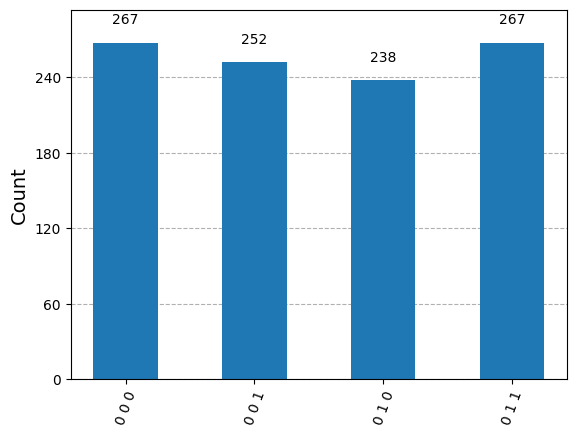

In [5]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [6]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [7]:
c = "1"
d = "0"

In [8]:
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw())

┌───┐      ░ ┌───┐ ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤ X ├─░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░ └───┘ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░───────░─┤ X ├──────░──╫─┤M├
             └───┘ ░       ░ └───┘      ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

Measured 10 with frequency 1.0


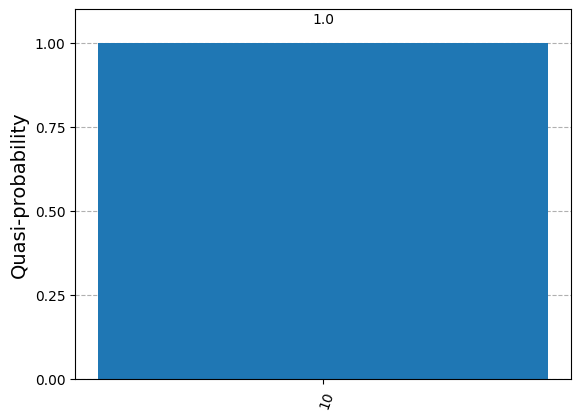

In [9]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

In [10]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw())

░ ┌───┐┌─┐┌───┐┌─┐ ░                                »
randomizer: ───────────░─┤ H ├┤M├┤ H ├┤M├─░────────────────────────────────»
            ┌───┐      ░ └───┘└╥┘└───┘└╥┘ ░ ┌────── ┌───┐ ───────┐ ┌────── »
         A: ┤ H ├──■───░───────╫───────╫──░─┤ If-0  ┤ Z ├  End-0 ├─┤ If-0  »
            └───┘┌─┴─┐ ░       ║       ║  ░ └──╥─── └───┘ ───────┘ └──╥─── »
         B: ─────┤ X ├─░───────╫───────╫──░────╫──────────────────────╫────»
                 └───┘ ░       ║       ║  ░ ┌──╨──┐                   ║    »
 Alice d: 1/═══════════════════╬═══════╩════╡ 0x1 ╞═══════════════════╬════»
                               ║       0    └─────┘                ┌──╨──┐ »
 Alice c: 1/═══════════════════╩═══════════════════════════════════╡ 0x1 ╞═»
                               0                                   └─────┘ »
   Bob d: 1/═══════════════════════════════════════════════════════════════»
                                                                           »
   Bob c: 1/═══════════════════════════════════════════════════════════════»
                                                                           »
«                            ░            ░       
«randomizer: ────────────────░────────────░───────
«            ┌───┐ ───────┐  ░      ┌───┐ ░ ┌─┐   
«         A: ┤ X ├  End-0 ├──░───■──┤ H ├─░─┤M├───
«            └───┘ ───────┘  ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
«         B: ────────────────░─┤ X ├──────░──╫─┤M├
«                            ░ └───┘      ░  ║ └╥┘
« Alice d: 1/════════════════════════════════╬══╬═
«                                            ║  ║ 
« Alice c: 1/════════════════════════════════╬══╬═
«                                            ║  ║ 
«   Bob d: 1/════════════════════════════════╩══╬═
«                                            0  ║ 
«   Bob c: 1/═══════════════════════════════════╩═
«                                               0

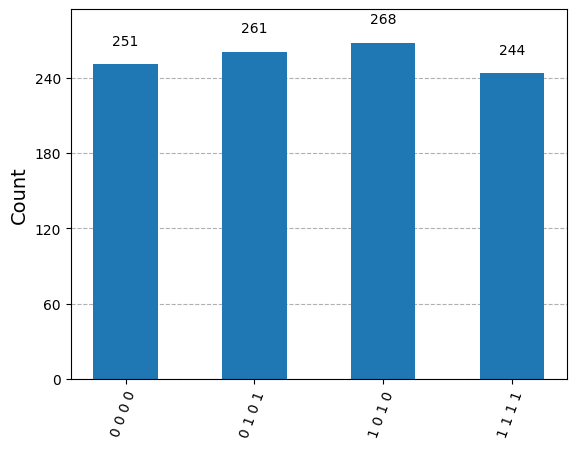

In [11]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))